Importing Libraries

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
csv_path = "/content/drive/MyDrive/prep2_train.csv"

In [4]:
df = pd.read_csv(csv_path)
df["polarization"] = df["polarization"].astype(int)

Train Split

In [5]:
train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)

Tokenizer Loading

In [6]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Load the Model

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset Class

In [8]:
class PolarDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["text"].tolist()
        self.labels = df["polarization"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = PolarDataset(train_data, tokenizer)
val_dataset = PolarDataset(val_data, tokenizer)

Metrics and Trainging Arguments

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

training_args = TrainingArguments(
    output_dir="./model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,

    logging_dir="./logs",
    logging_steps=50,
    report_to=[],

    eval_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,

    fp16=True
)

Trainer

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Training

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.572400,0.622184,0.722772,0.782353,0.639423,0.703704
2,0.560400,0.555174,0.745050,0.733333,0.793269,0.762125
3,0.486500,0.591973,0.757426,0.745536,0.802885,0.773148


TrainOutput(global_step=1365, training_loss=0.5561701778090481, metrics={'train_runtime': 371.9064, 'train_samples_per_second': 29.33, 'train_steps_per_second': 3.67, 'total_flos': 1435007695933440.0, 'train_loss': 0.5561701778090481, 'epoch': 3.0})

Results

In [17]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.5919727087020874, 'eval_accuracy': 0.7574257425742574, 'eval_precision': 0.7455357142857143, 'eval_recall': 0.8028846153846154, 'eval_f1': 0.7731481481481481, 'eval_runtime': 1.6412, 'eval_samples_per_second': 246.16, 'eval_steps_per_second': 31.075, 'epoch': 3.0}


Save Model

In [20]:
trainer.save_model("./model")
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/sentencepiece.bpe.model',
 './model/added_tokens.json',
 './model/tokenizer.json')

Manual Test

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("./model")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [24]:
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [25]:
text = "911 is done by israel and israel should die and it is corrupt"

In [26]:
inputs = tokenizer(
    text,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

In [27]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

print(predicted_class)
if predicted_class == 1:
    print("Polarized")
else:
    print("Not Polarized")

1
Polarized


In [28]:
model.save_pretrained("/content/drive/MyDrive/my_model_1")
tokenizer.save_pretrained("/content/drive/MyDrive/my_model_1")

('/content/drive/MyDrive/my_model_1/tokenizer_config.json',
 '/content/drive/MyDrive/my_model_1/special_tokens_map.json',
 '/content/drive/MyDrive/my_model_1/sentencepiece.bpe.model',
 '/content/drive/MyDrive/my_model_1/added_tokens.json',
 '/content/drive/MyDrive/my_model_1/tokenizer.json')

Plots and Metrics

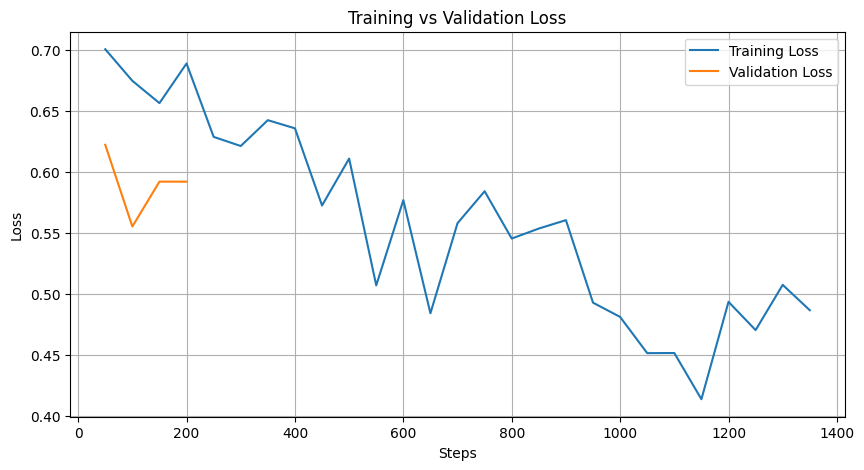

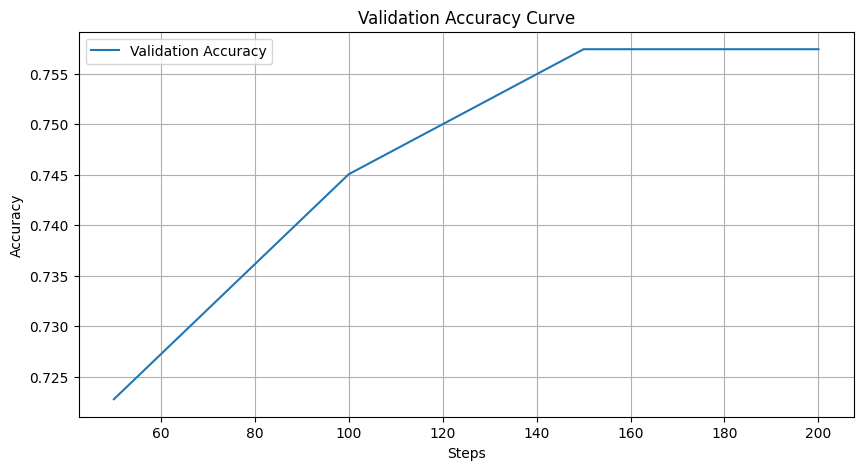

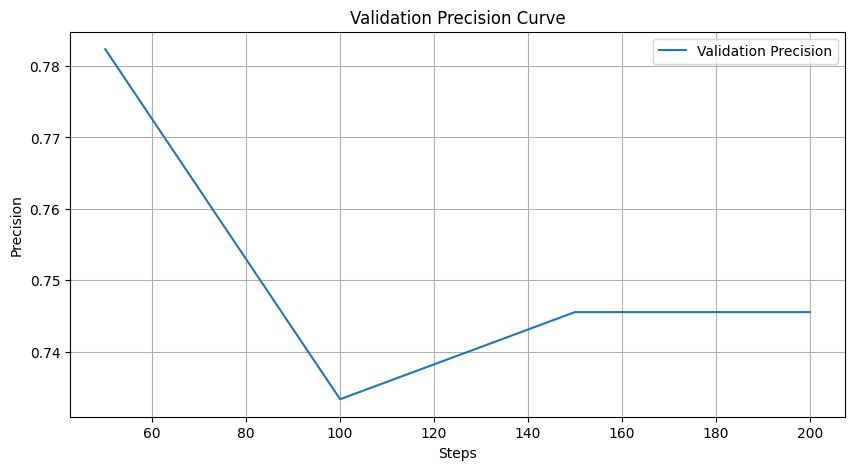

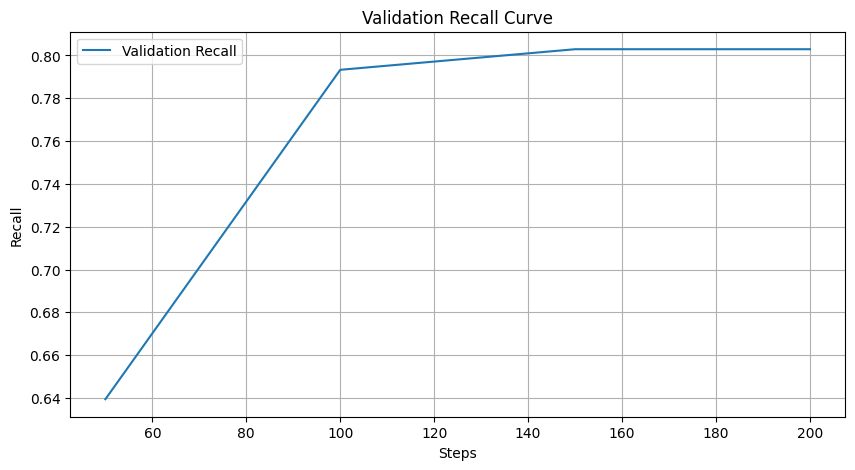

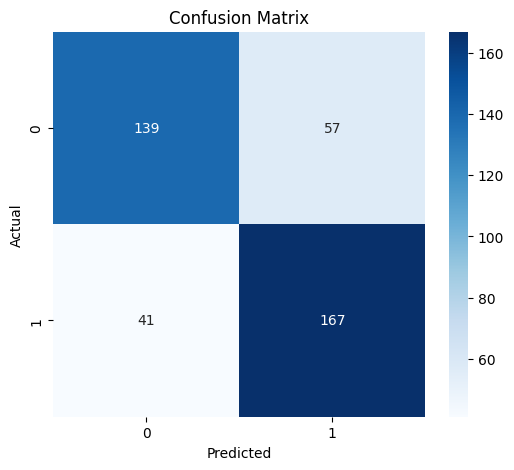

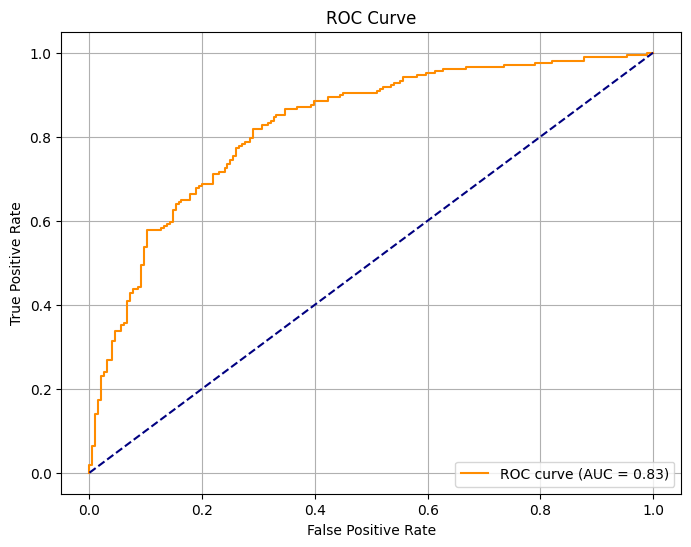

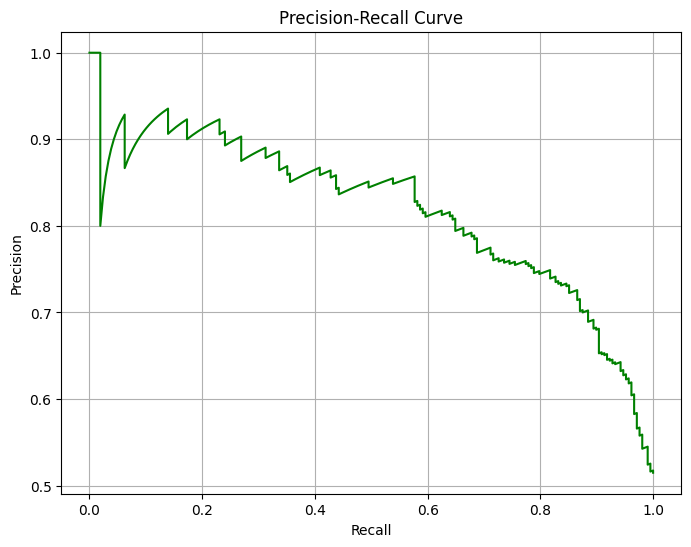

In [29]:
log_history = trainer.state.log_history

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
steps = []

for entry in log_history:
    if "loss" in entry:
        train_losses.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        val_losses.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        val_accuracies.append(entry["eval_accuracy"])
    if "eval_precision" in entry:
        val_precisions.append(entry["eval_precision"])
    if "eval_recall" in entry:
        val_recalls.append(entry["eval_recall"])

plt.figure(figsize=(10,5))
plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
plt.plot(steps[:len(val_losses)], val_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(steps[:len(val_accuracies)], val_accuracies, label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(steps[:len(val_precisions)], val_precisions, label="Validation Precision")
plt.xlabel("Steps")
plt.ylabel("Precision")
plt.title("Validation Precision Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(steps[:len(val_recalls)], val_recalls, label="Validation Recall")
plt.xlabel("Steps")
plt.ylabel("Recall")
plt.title("Validation Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

def get_predictions(model, dataset):
    model.eval()
    preds = []
    labels = []
    loader = DataLoader(dataset, batch_size=16)
    with torch.no_grad():
        for batch in loader:
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            pred = torch.argmax(outputs.logits, dim=1)
            preds.extend(pred.tolist())
            labels.extend(batch["labels"].tolist())
    return labels, preds

true_labels, pred_labels = get_predictions(model, val_dataset)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc, precision_recall_curve

probs = []
labels_list = []
model.eval()
loader = DataLoader(val_dataset, batch_size=16)
with torch.no_grad():
    for batch in loader:
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        prob = torch.softmax(outputs.logits, dim=1)[:,1]
        probs.extend(prob.tolist())
        labels_list.extend(batch["labels"].tolist())

fpr, tpr, _ = roc_curve(labels_list, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(labels_list, probs)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

metrics_data = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_accuracy": val_accuracies,
    "val_precision": val_precisions,
    "val_recall": val_recalls,
    "confusion_matrix": cm.tolist()
}

with open("training_metrics.json", "w") as f:
    json.dump(metrics_data, f, indent=4)